In [1]:
from oniakIO import odats
import pathlib, os

root_path = pathlib.Path("/media/gtnetuser/SSD_2TB_BEST/LpSubspace")
gt_dist = odats.read_file(str(root_path / "result/distance_preserve/gnd.odat"))
gt_dist.shape

(100, 100)

In [2]:
import numpy as np

def load_results(code):
    dirpath = root_path / "result" / code
    exp_list = os.listdir(str(root_path /"result" / code)) 
    results = np.empty((len(exp_list), 100, 100))
    cnt = 0
    for filename in exp_list:
        if "gnd" in filename:
            continue
        if code == "dpl1" and "sj" not in filename:
          continue
        full_name = str(dirpath / filename)
        data = odats.read_file(full_name)
        if data.shape != (100, 100):
            continue
        results[cnt] = data
        cnt += 1
    return results[:cnt]

l2_results = load_results("distance_preserve")
l1_results = load_results("dpl1")
l2_results.shape, l1_results.shape

((10000, 100, 100), (10000, 100, 100))

In [3]:
from oniakExp import stats

nbins = 1000
num_setting = 10000

def get_pdf(data):
    assert(data.shape[0] == num_setting)
    data = data / gt_dist[np.newaxis, :, :]

    pdfs = np.empty((num_setting, nbins))
    for i in range(num_setting):
        x = i // 100
        y = i % 100
        pdfs[i] = stats.cdf(data[:, x, y], limits=[0, 300], nbins=nbins)
    pdfs = pdfs[np.sum(pdfs,axis=1).argsort()]
    return pdfs

l1_pdfs = get_pdf(l1_results)
l2_pdfs = get_pdf(l2_results)
l1_pdfs.shape, l2_pdfs.shape


((10000, 1000), (10000, 1000))

In [3]:
from oniakExp import stats
nbins = 1000
num_setting = 10000

def get_pdf2(data):
    assert(data.shape[0] == num_setting)
    data = data / gt_dist[np.newaxis, :, :]

    pdfs = np.empty((num_setting, nbins))
    for i in range(num_setting):
        x = i // 100
        y = i % 100
        pdfs[i] = stats.icdf(data[:, x, y], nbins=nbins)
    pdfs = pdfs[np.sum(pdfs,axis=1).argsort()]
    return pdfs

l1_icdfs = get_pdf2(l1_results)
l2_icdfs = get_pdf2(l2_results)
l1_icdfs.shape, l2_icdfs.shape

((10000, 1000), (10000, 1000))

In [4]:
odats.write_file("result/l1_pdfs.odat", l1_pdfs)
odats.write_file("result/l2_pdfs.odat", l2_pdfs)

80040001

In [4]:
from oniakIO import odats
import numpy as np
l1_pdfs = odats.read_file("result/l1_pdfs.odat")
l2_pdfs = odats.read_file("result/l2_pdfs.odat")
nbins = l1_pdfs.shape[1]

In [33]:
l1_avg2 = np.mean(l1_icdfs, axis=0)
l2_avg2 = np.mean(l2_icdfs, axis=0)
l1_avg = np.mean(l1_pdfs, axis=0)
l2_avg = np.mean(l2_pdfs, axis=0)
l1_med = l1_avg2[len(l1_avg2) // 2]
l2_med = l2_avg2[len(l1_avg2) // 2]
l1_avg.shape, l2_avg.shape, l1_med, l2_med

((1000,), (1000,), 28.92311709415198, 58.75869456712138)

In [34]:
from scipy.stats import binom
def get_beta(recall, cs, q1, q2, l, t):
    q1 = 1 - binom.cdf(t-1, l, q1)
    q2 = 1 - binom.cdf(t-1, l, q2)
    threshold = np.searchsorted(q1, recall)
    result = np.zeros_like(cs)
    for i, c in enumerate(cs):
        threshold_c = int(threshold / c)
        threshold_c = -1 if threshold_c >= len(q2) else threshold_c
        result[i] = q2[threshold_c]
    return result

c_list = np.linspace(1, 4, 401)
beta1 = get_beta(0.9, c_list, l1_pdfs[4937], l1_avg, 1, 1)
beta2 = get_beta(0.9, c_list, l2_pdfs[4762], l2_avg, 12, 3)

In [31]:
def sort_all(arr):
  ac = arr.copy()
  for i in range(ac.shape[1]):
    ac[:, i] = np.sort(ac[:, i])
  return ac

l1_copy = sort_all(l1_icdfs)
l2_copy = sort_all(l2_icdfs)

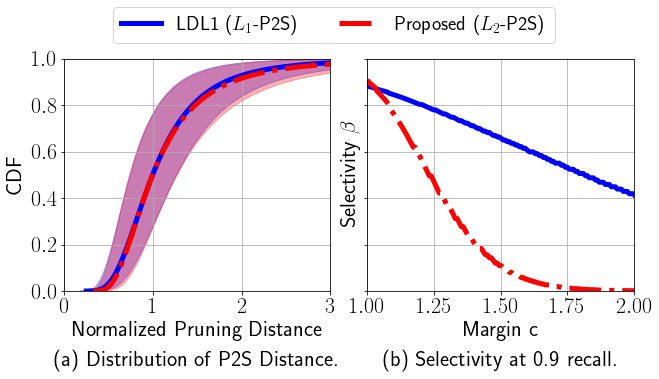

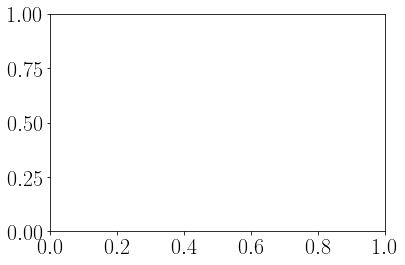

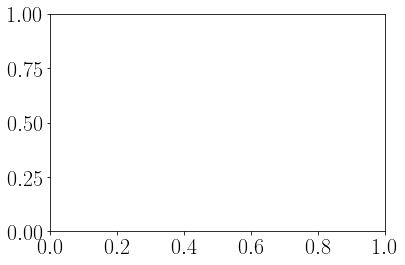

In [35]:
from oniakPlot import line_plot
import importlib
importlib.reload(line_plot)
import matplotlib.pyplot as plt

xs = np.linspace(0, 999, nbins)
l1_avg3 = l1_avg2 / l1_med
l2_avg3 = l2_avg2 / l2_med
l1_copy2 = l1_copy / l1_med
l2_copy2 = l2_copy / l2_med
ys = np.linspace(0, 1, nbins)
xs = np.linspace(0, 300, nbins)

fig, (a1,a2) = plt.subplots(1,2, figsize = (9, 4), sharey=True)
fig.tight_layout()
ax = line_plot.plot_result([(l1_avg3, ys), (l2_avg3, ys)], 
                      line_names=["LDL1 ($L_1$-P2S)", "Proposed ($L_2$-P2S)"], xlabel="Normalized Pruning Distance", ylabel="CDF", 
                      markers=["","", ""], linestyles=["-","-.", ":"], linewidth=5, legend_pos="lower right",
                      figtitle="", limx=[0, 3], savepath="", grid=True, ax=a1, showlegend=False, colors=["blue", "red", "red"])
ax.fill_betweenx(ys, l1_copy2[1000], l1_copy2[9000], alpha=0.3, color="blue")
ax.fill_betweenx(ys, l2_copy2[1000], l2_copy2[9000], alpha=0.3, color="red")
ax.set_title("(a) Distribution of P2S Distance.", y=-0.35)
ax = line_plot.plot_result([(c_list, beta1), (c_list, beta2)], 
                      line_names=None, xlabel="Margin c", ylabel=r"Selectivity $\beta$", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right",
                      figtitle="", limx=[1, 2], limy=[0, 1], savepath="", grid=True, ax=a2, showlegend=False)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='outside upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
ax.set_title("(b) Selectivity at 0.9 recall.", y=-0.35)
fig.savefig("../result/p2s_dist_big.pdf", bbox_inches="tight")


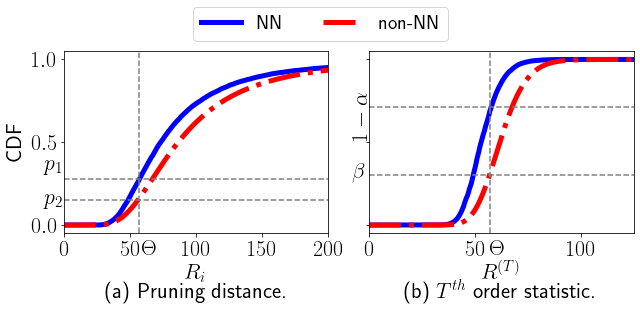

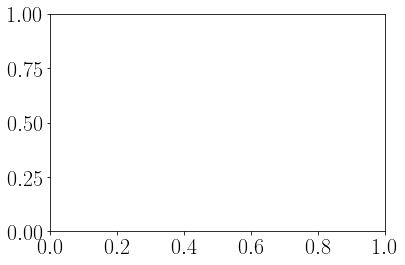

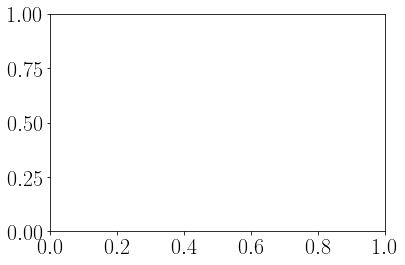

In [10]:
xs = np.linspace(0, 300, nbins)
fig, (a1,a2) = plt.subplots(1,2, figsize = (9, 4), sharey=True)

ax = line_plot.plot_result([(xs, l2_pdfs[1000]), (xs * 1.5, l2_avg)], 
                      line_names=["NN", "non-NN"], xlabel=r"$R_i$", ylabel="CDF", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right", colors=["blue", "red"],
                      figtitle="", limx=[0, 200], savepath="", ax=a1, showlegend=False)
ax.axvline(x=57, linestyle="--", color="gray")
ax.axhline(y=0.28, linestyle="--", color="gray")
ax.axhline(y=0.15, linestyle="--", color="gray")
ax.text(-16, 0.33, '$p_1$', fontsize = 22)
ax.text(-16, 0.12, '$p_2$', fontsize = 22)
ax.text(59, -0.18, r'$\Theta$', fontsize = 22)
ax.set_title("(a) Pruning distance.", y=-0.39)

from scipy.stats import binom
l2_1000t = 1 - binom.cdf(2, 12, l2_pdfs[1000])
l2_avgt = 1 - binom.cdf(2, 12, l2_avg)
ax = line_plot.plot_result([(xs, l2_1000t), (xs * 1.5, l2_avgt)], 
                      line_names=None, xlabel=r"$R^{(T)}$", ylabel="", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right", colors=["blue", "red"],
                      figtitle="", limx=[0, 125], savepath="", ax=a2, showlegend=False)
ax.axvline(x=57, linestyle="--", color="gray")
ax.axhline(y=0.3, linestyle="--", color="gray")
ax.axhline(y=0.71, linestyle="--", color="gray")
ax.text(-8, 0.28, r'$\beta$', fontsize = 22)
ax.text(-8, 0.53, r'$1-\alpha$', fontsize = 22, rotation=90)
ax.text(57, -0.18, r'$\Theta$', fontsize = 22)
ax.set_title(r"(b) $T^{th}$ order statistic.", y=-0.39)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,loc='outside upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
fig.tight_layout()
fig.savefig("../result/theta_big.pdf", bbox_inches="tight")

In [11]:
def rho(p1, p2):
    p1[p1 < 0.1] = np.nan
    p2[p2 < 0.00001] = np.nan
    p1[p1 < p2] = np.nan
    return (p1 - p2) * (p1 - p2) / p2 / (1 - p2)

def best_rho(cs, q1, q2, argmin=False):
    result = np.zeros_like(cs)
    argresult = np.zeros_like(cs, dtype=np.int32)
    for i, c in enumerate(cs):
        qsize = len(q1)
        far_size = int(qsize / c)
        fars = np.linspace(0, far_size-1, far_size, dtype=np.int32)
        nears = (fars * c).astype(np.int32)
        qnear = q1[nears]
        qfar = q2[fars]
        rhos = rho(qnear, qfar)
        result[i] = np.nanmax(rhos)
        # if not (np.isnan(rhos)).all():
        #   argresult[i] = np.nanargmax(rhos)
        #   print(c, qnear[argresult[i]], qfar[argresult[i]])
    return result

c_list = np.linspace(1, 2.0, 21)
rhos1 = []
rhos2 = []
for i in range(10000):
    rhos1.append(best_rho(c_list, l1_pdfs[i], l1_avg))
    rhos2.append(best_rho(c_list, l2_pdfs[i], l2_avg))
# rho11, argrho11 = best_rho(c_list, l1_pdfs[1000], l1_avg)
# rho12, argrho12 = best_rho(c_list, l1_pdfs[5000], l1_avg, argmin=True)
# rho13, argrho13 = best_rho(c_list, l1_pdfs[9000], l1_avg, argmin=True)
# rho21, argrho21 = best_rho(c_list, l2_pdfs[1000], l2_avg, argmin=True)
# rho22, argrho22 = best_rho(c_list, l2_pdfs[5000], l2_avg, argmin=True)
# rho23, argrho23 = best_rho(c_list, l2_pdfs[9000], l2_avg, argmin=True)

/tmp/ipykernel_799453/491666786.py:18: RuntimeWarning: All-NaN slice encountered
  result[i] = np.nanmax(rhos)


In [12]:
rhos1 = np.array(rhos1)
rhos2 = np.array(rhos2)
rhos1arg = np.argsort(rhos1[:, 20])
rhos2arg = np.argsort(rhos2[:, 20])
rhos1 = rhos1[rhos1arg]
rhos2 = rhos2[rhos2arg]
rho11 = rhos1[1000]
rho12 = rhos1[5000]
rho13 = rhos1[9000]
rho21 = rhos2[1000]
rho22 = rhos2[5000]
rho23 = rhos2[9000]
rho1idx = rhos1arg[5000]
rho2idx = rhos2arg[5000]
rho1idx, rho2idx

(4937, 4762)

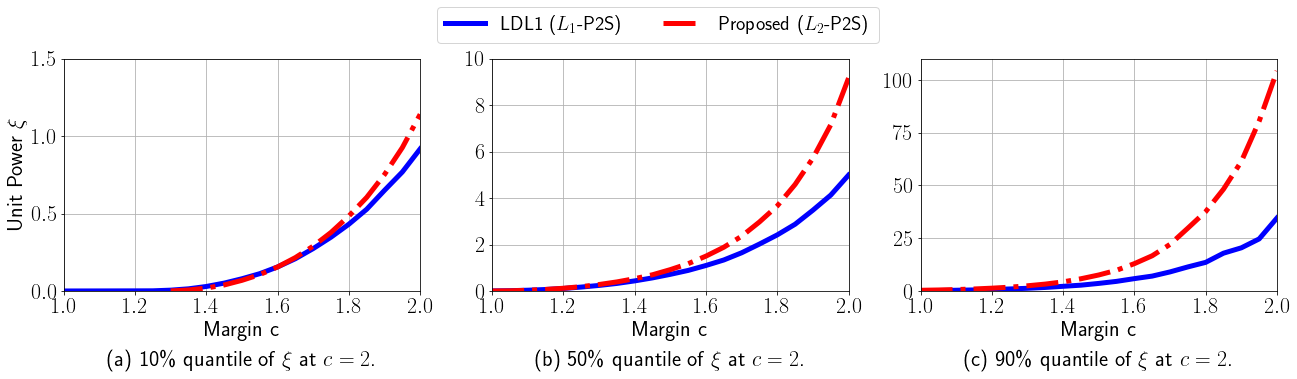

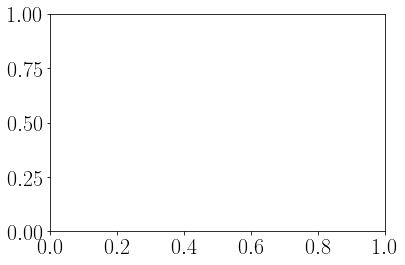

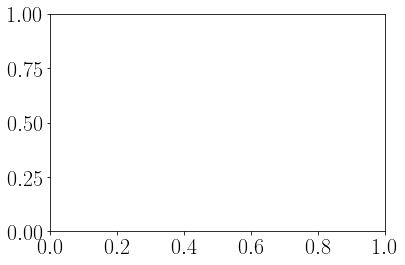

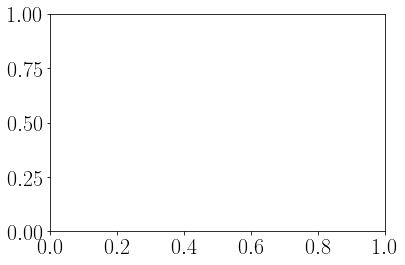

In [13]:
fig, (a1,a2, a3) = plt.subplots(1,3, figsize = (18, 4), sharey=False)
fig.tight_layout()

ax = line_plot.plot_result([(c_list, rho11), (c_list, rho21)], 
                      line_names=["LDL1 ($L_1$-P2S)", "Proposed ($L_2$-P2S)"], xlabel="Margin c", ylabel=r"Unit Power $\xi$", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right",
                      figtitle="", limx=[1, 2], limy=[0, 1.5], savepath="", grid=True, ax=a1, showlegend=False)
ax.set_title(r"(a) 10\% quantile of $\xi$ at $c=2$.", y=-0.35)
ax = line_plot.plot_result([(c_list, rho12), (c_list, rho22)], 
                      line_names=None, xlabel="Margin c", ylabel="", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right",
                      figtitle="", limx=[1, 2], limy=[0, 10], savepath="", grid=True, ax=a2, showlegend=False)
ax.set_title(r"(b) 50\% quantile of $\xi$ at $c=2$.", y=-0.35)
ax = line_plot.plot_result([(c_list, rho13), (c_list, rho23)], 
                      line_names=None, xlabel="Margin c", ylabel="", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right",
                      figtitle="", limx=[1, 2], limy=[0, 110], savepath="", grid=True, ax=a3, showlegend=False)
ax.set_title(r"(c) 90\% quantile of $\xi$ at $c=2$.", y=-0.35)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='outside upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
fig.savefig("../result/rho_big.pdf", bbox_inches="tight")

In [14]:
l_max = 500
q_computed = {}

def get_beta2(recall, cs, q, l, t):
    if (l, t) in q_computed.keys():
        qt = q_computed[l, t]
    else:
        qt = 1 - binom.cdf(t-1, l, q)
        q_computed[l, t] = qt
    threshold = np.searchsorted(qt, recall)
    result = np.zeros_like(cs)
    for i, c in enumerate(cs):
        threshold_c = int(threshold / c)
        threshold_c = -1 if threshold_c >= len(qt) else threshold_c
        result[i] = qt[threshold_c]
    return result


def get_eta(alphas, q, cs):
    results = np.zeros((len(alphas), len(cs)))
    for j, alpha in enumerate(alphas):
        for i, c in enumerate(cs):
            eta = 0
            flag2 = 0
            cl = None
            for l in range(l_max):
                eta_t = 0
                flag = 0
                ct = None
                for t in range(1, l+1):
                    beta = get_beta2(0.9, [c], q, l, t)
                    cur_eta = 1 / (l/alpha + beta)
                    if cur_eta > eta_t:
                        eta_t = cur_eta
                        ct = t
                    else:
                        flag+= 1
                    if flag > 10:
                        break
                if eta_t > eta:
                    eta = eta_t
                    flag2 += 1
                    cl = (l, ct)
                else:
                    flag2+= 1
                    if flag2 > 10:
                        break
            results[j, i] = eta
    return results

In [15]:
c_list = np.linspace(1, 3, 201)
eta_c = get_eta([900], l2_avg, c_list)[0]
eta_c2 = get_eta([90], l2_avg, c_list)[0]

/tmp/ipykernel_799453/2351972800.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[j, i] = eta


In [16]:
a_list = np.logspace(1, 4, 301)
eta_a = get_eta(a_list, l2_avg, [1.5])
eta_a2 = get_eta(a_list, l2_avg, [1.2])
eta_a3 = get_eta(a_list, l2_avg, [1.3])
eta_a4 = get_eta(a_list, l2_avg, [2])

/tmp/ipykernel_799453/2351972800.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[j, i] = eta


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


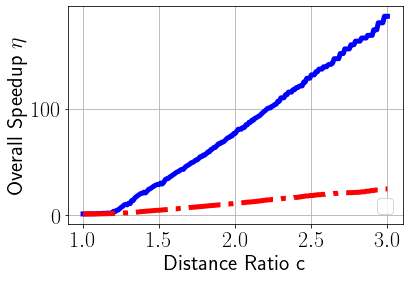

In [17]:
ax = line_plot.plot_result([(c_list, eta_c), (c_list, eta_c2),], 
                      line_names=None, xlabel="Distance Ratio c", ylabel=r"Overall Speedup $\eta$", 
                      markers=["",""], linestyles=["-","-."], linewidth=5, legend_pos="lower right",
                      figtitle="", savepath="", grid=True)
plt.savefig("../result/p2s_eta_c.pdf", bbox_inches="tight")
plt.show()

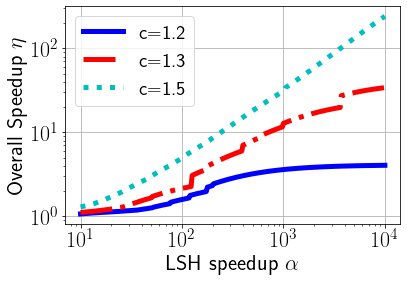

In [18]:
ax = line_plot.plot_result([(a_list, eta_a2), (a_list, eta_a3), (a_list, eta_a)], 
                      line_names=["c=1.2", "c=1.3", "c=1.5", "c=2"], xlabel=r"LSH speedup $\alpha$", ylabel=r"Overall Speedup $\eta$", 
                      markers=["","", "", ""], linestyles=["-","-.", ":", "--"], linewidth=5, legend_pos="best",
                      figtitle="", savepath="", grid=True, logx=True, logy=True)
plt.savefig("../result/p2s_eta_a.pdf", bbox_inches="tight")